# Setup
### Importing Required Libraries

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import requests

### Download dataset

In [7]:
filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'
df = pd.read_csv(filepath, header=None)

df.head()

,0,1,2,3,4,5,6
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520


In [9]:
#Import the dataset into a pandas dataframe
#Print the first 10 rows of the dataframe to confirm successful loading:
print(df.head(10))

    0  1       2  3  4  5            6
0  19  1  27.900  0  1  3  16884.92400
1  18  2  33.770  1  0  4   1725.55230
2  28  2  33.000  3  0  4   4449.46200
3  33  2  22.705  0  0  1  21984.47061
4  32  2  28.880  0  0  1   3866.85520
5  31  1  25.740  0  ?  4   3756.62160
6  46  1  33.440  1  0  4   8240.58960
7  37  1  27.740  3  0  1   7281.50560
8  37  2  29.830  2  0  2   6406.41070
9  60  1  25.840  0  0  1  28923.13692


# Data Cleaning

In [10]:
#Add the headers:
headers = ['Age','Gender','BMI','No_of_Children','Smoker','Region','Charges']
df.columns = headers

In [11]:
#Replace '?' entries with 'NaN' values:
df.replace('?', np.nan, inplace = True)

In [12]:
#Identify the columns that have some 'Null'(or Nan):
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2768 non-null   object 
 1   Gender          2772 non-null   int64  
 2   BMI             2772 non-null   float64
 3   No_of_Children  2772 non-null   int64  
 4   Smoker          2765 non-null   object 
 5   Region          2772 non-null   int64  
 6   Charges         2772 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB
None


In [18]:
#Populate missing data:

#For continuous attributes (e.g.,age), replace with the mean
mean_age = df['Age'].astype('float').mean(axis=0)
df['Age'].replace(np.nan, mean_age, inplace=True)

#For categorical attributes(e.g.,smoker), replace with the most frequent value
is_smoker = df['Smoker'].value_counts().idxmax()
df['Smoker'].replace(np.nan, is_smoker, inplace=True)

#Update the data types of the respective columns
df[['Age','Smoker']] = df[['Age', 'Smoker']].astype('int')

#Verify the update:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2772 non-null   int32  
 1   Gender          2772 non-null   int64  
 2   BMI             2772 non-null   float64
 3   No_of_Children  2772 non-null   int64  
 4   Smoker          2772 non-null   int32  
 5   Region          2772 non-null   int64  
 6   Charges         2772 non-null   float64
dtypes: float64(2), int32(2), int64(3)
memory usage: 130.1 KB
None


In [21]:
#Update charges column to round values to nearest 2 decimal places
df[['Charges']] = np.round(df[['Charges']],2)

#Verify conversion
print(df.head())

   Age  Gender     BMI  No_of_Children  Smoker  Region   Charges
0   19       1  27.900               0       1       3  16884.92
1   18       2  33.770               1       0       4   1725.55
2   28       2  33.000               3       0       4   4449.46
3   33       2  22.705               0       0       1  21984.47
4   32       2  28.880               0       0       1   3866.86


# Exploratory Data Analysis

(0.0, 66902.85800000001)

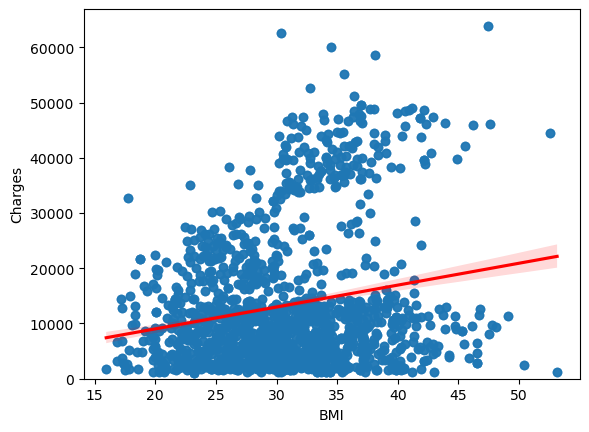

In [22]:
#Implement the regression plot for charges with respect to bmi:
sns.regplot(x='BMI', y='Charges', data=df, line_kws={"color":"red"})
plt.ylim(0,)

<Axes: xlabel='Smoker', ylabel='Charges'>

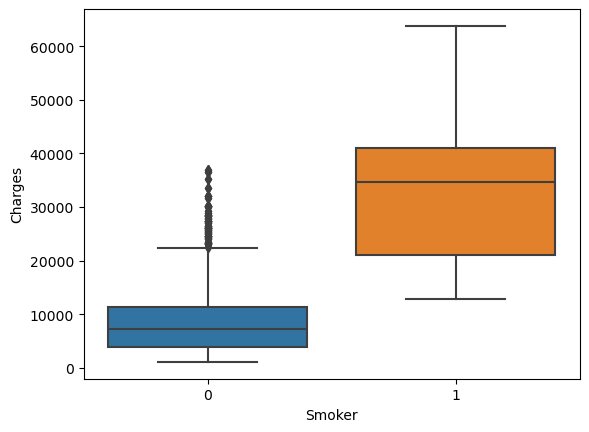

In [23]:
#Implement the box plot for charges with respect to smoker:
sns.boxplot(x='Smoker', y='Charges', data=df)

In [24]:
#Print the correlation matrix for the dataset:
print(df.corr())

                     Age    Gender       BMI  No_of_Children    Smoker  \
Age             1.000000 -0.026046  0.113048        0.037574 -0.023286   
Gender         -0.026046  1.000000  0.042924        0.016020  0.082326   
BMI             0.113048  0.042924  1.000000       -0.001492  0.011489   
No_of_Children  0.037574  0.016020 -0.001492        1.000000  0.006362   
Smoker         -0.023286  0.082326  0.011489        0.006362  1.000000   
Region         -0.007167  0.022213  0.271119       -0.025717  0.054077   
Charges         0.298624  0.062837  0.199846        0.066442  0.788783   

                  Region   Charges  
Age            -0.007167  0.298624  
Gender          0.022213  0.062837  
BMI             0.271119  0.199846  
No_of_Children -0.025717  0.066442  
Smoker          0.054077  0.788783  
Region          1.000000  0.054058  
Charges         0.054058  1.000000  


# Model Development

In [26]:
#Fit a linear regression model that may be used to predict the charges value
#Use the smoker attribute of the dataset
#Print the R^2 score of this model
X = df[['Smoker']]
Y = df[['Charges']]
lm = LinearRegression()
lm.fit(X,Y)
print("The R^2 of the model is",lm.score(X,Y))

THe R^2 of the model is 0.6221791733924185


In [28]:
#Fit a linear regression model that use all other attributes
#Predict the charges value
#Print the R^2 of this model
Z = df[['Age','Gender','BMI','No_of_Children','Region']]
Y = df[['Charges']]
lm.fit(Z,Y)
print("The R^2 of the model is",lm.score(X1,Y))

The R^2 of the model is 0.12426185633470044


In [29]:
#Create a model that can predict the charges value using all other attributes
#Create a training pipleine that uses StandardScaler, PolynomialFeatures, LinearRegression
Input = [('scale',StandardScaler()),('polynomial',PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
Z = Z.astype(float)
pipe.fit(Z,Y)
ypipe=pipe.predict(Z)
print("The R^2 of this model is", r2_score(Y,ypipe))

The R^2 of this model is 0.13742867674035786


# Model Refinement

In [30]:
#Split the data into training and testing subsets, set 20% for testing:
x_train, x_test, y_train, y_test = train_test_split(Z,Y,test_size = 0.20, random_state=1)

In [31]:
#Initialize a Ridge regressor that use alpha=0.1
RigeModel = Ridge(alpha=0.1)

#Fit the model using training data
RigeModel.fit(x_train, y_train)
yhat = RigeModel.predict(x_test)

#Print R^2 score for the testing data
print("The R^2 for testing data is", r2_score(y_test, yhat))

The R^2 for testing data is 0.08006811608292919


In [32]:
#Apply polynomial tranformation to the training parameters with degree==2
#Use this transormed feature set to fit the same regression model
#Print the R^2 for the testing subset

pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
RigeModel.fit(x_train_pr, y_train)
y_hat = RigeModel.predict(x_test_pr)

print(r2_score(y_test,y_hat))

0.0924978829998705
